In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib
import seaborn as sns
from scipy.signal import savgol_filter

### Dose-response curves

In [2]:
# Hill equation 
def func(X, EC50, h):
    return b + (a-b)/(1 + (EC50/X)**h)

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/15177

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/Users/alyssachiang/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/3825221551.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=8)
/v

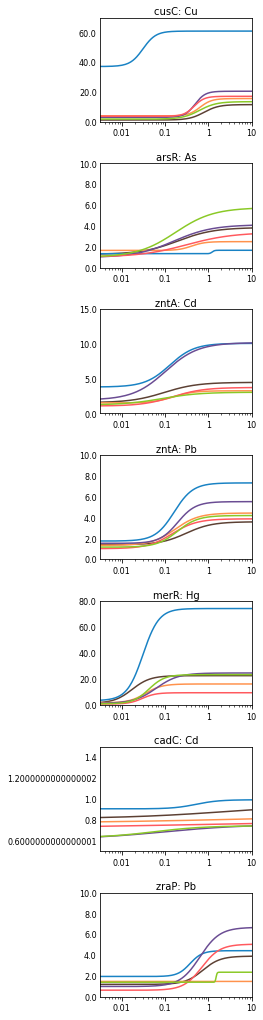

In [3]:
dose_df = pd.read_csv('dose_response.csv',index_col=0)

# Get all sensors + heavy metal combinations 
metal_sensor = pd.DataFrame(columns=['hm','sensor'])
hm = ['Cu','As','Cd','Pb','Hg','Cd','Pb']
sensor = ['cusC','arsR','zntA','zntA','merR','cadC','zraP']
metal_sensor['hm'] = hm
metal_sensor['sensor'] = sensor

fit_e_hm9sea = pd.DataFrame(columns=['hm','sensor','a','b','EC50','EC50_std','h','h_std','strain','cond'])


# Get colors for sensors 
colors = {'MG':'#5C4033' , 'ALE1':'#1982c4', 'ALE2':'#ff924c', 'ALE3':'#6a4c93', 'ALE4':'#ff595e','ALE5':'#8ac926'}
e_strains = ['MG','ALE1','ALE2','ALE3','ALE4','ALE5']

# Make plots [i=sensor,j=strain]
fig, axes = plt.subplots(7, 1, figsize=(3, 16), facecolor='white')  
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.95, wspace=0.3, hspace=0.4)

# Get each condition 
for i in range(0, len(metal_sensor)): 
    curr = metal_sensor.iloc[i]
    
    for j in range(0,len(e_strains)):
        
        data = dose_df.loc[(dose_df['hm'] == curr.hm) & (dose_df['sensor'] == curr.sensor) & (dose_df['strain'] == e_strains[j])]    
           
        # Get the means, stds, and Hill fit data 
        conc = data['ppm'].unique()
        means = []
        stds = []
        for ppm in conc: 
            x = data[data.ppm == ppm]['max'].mean()
            u = data[data.ppm == ppm]['max'].std()
            means.append(x)
            stds.append(u)
        a = np.max(means)
        b = means[0]
        
        # Fit Hill curve
        ## ADD EXCEPTIONS (IF APPLICABLE) - EXCLUSIONS AS DESCRIBED IN TEXT 
        if curr.sensor == 'cusC' and e_strains[j] == 'ALE3':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.sensor == 'cusC' and e_strains[j] == 'ALE1':
            popt, pcov = curve_fit(func,conc[0:5],means[0:5])
        elif curr.sensor == 'cusC' and e_strains[j] == 'ALE4':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Cd' and curr.sensor == 'zntA' and e_strains[j] == 'ALE1':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Cd' and curr.sensor == 'zntA' and e_strains[j] == 'ALE2':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Pb' and curr.sensor == 'zntA':
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
        elif curr.sensor == 'merR' and e_strains[j] == 'ALE1': 
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
        elif curr.sensor == 'merR': 
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
            if e_strains[j] == 'ALE3':
                popt, pcov = curve_fit(func,conc[0:10],means[0:10])
        elif curr.sensor == 'merR' and e_strains[j] == 'ALE3': 
            popt, pcov = curve_fit(func,conc[0:10],means[0:10])
        else: 
            popt, pcov = curve_fit(func,conc,means)
            
        EC50 = popt[0]
        h = popt[1]
        std_dev_params = np.sqrt(np.diag(pcov))
        EC50_std = std_dev_params[0]
        h_std = std_dev_params[1]

        fit_e_hm9sea.loc[len(fit_e_hm9sea)] = [curr.hm,curr.sensor,a,b,EC50,EC50_std,h,h_std,e_strains[j],'HM9+sea']

        # Plotting 
        ax = axes[i]
        endpt = 10      
        ax.plot(np.linspace(0,endpt,10000),func(np.linspace(0,endpt,10000),popt[0],popt[1]), color=colors[e_strains[j]], label=e_strains[j])
        ax.plot(np.linspace(endpt,200,100),func(np.linspace(endpt,200,100),popt[0],popt[1]), '--', alpha=0.3, color=colors[e_strains[j]])

        # Axes and x-ticks 
        ax.set_xscale('log')
        ax.tick_params(axis='y',length=0)
        xticks = [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,fontsize=8)
        ax.set_title(curr.sensor+': '+curr.hm, fontsize=10, pad=3)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # y-ticks 
        if curr.hm == 'Cu':
            ax.set_ylim(0,70)
        elif curr.hm == 'As': 
            ax.set_ylim(0,10)
        elif curr.hm == 'Cd' and curr.sensor == 'zntA':
            ax.set_ylim(0,15)
        elif curr.hm == 'Hg':
            ax.set_ylim(0,80)
        elif curr.hm == 'Cd' and curr.sensor == 'cadC':
            ax.set_ylim(0.5,1.5)
        elif curr.hm == 'Pb' and curr.sensor == 'zraP':
            ax.set_ylim(0,10)
        elif curr.hm == 'Pb' and curr.sensor == 'zntA':
            ax.set_ylim(0,10)
        ax.set_xlim(10**-2.5,10**1)
        ax.set_yticklabels(ax.get_yticks(),fontsize=8)

#### Dose-response curves (separated)

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedForm

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1517715069.py:3: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_42646/1996232157.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)
/var/folders/r4/n0pt1c0x7q

Text(0.5, 0, 'Metal Concentration (ppm)')

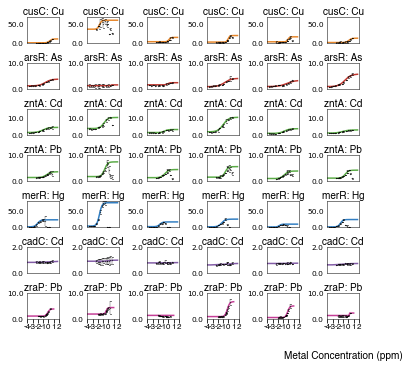

In [6]:
dose_df = pd.read_csv('dose_response.csv',index_col=0)

# Get all sensors + heavy metal combinations 
metal_sensor = pd.DataFrame(columns=['hm','sensor'])
hm = ['Cu','As','Cd','Pb','Hg','Cd','Pb']
sensor = ['cusC','arsR','zntA','zntA','merR','cadC','zraP']
metal_sensor['hm'] = hm
metal_sensor['sensor'] = sensor

fit_e_hm9sea = pd.DataFrame(columns=['hm','sensor','a','b','EC50','EC50_std','h','h_std','strain','cond'])

# Get colors for sensors 
colors = {'cusC':'#E7872B' , 'arsR':'#C03830', 'zntA':'#5AAA46', 'merR':'#317EC2', 'cadC':'#825CA6', 'zraP':'#C43E96'}
e_strains = ['MG','ALE1','ALE2','ALE3','ALE4','ALE5']

# Make plots [i=sensor,j=strain]
fig, axes = plt.subplots(7, 6, figsize=(5, 5), facecolor='white',constrained_layout=True)  
for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Adjust the value as needed



# Get each condition 
for i in range(0, len(metal_sensor)): 
    curr = metal_sensor.iloc[i]
    
    for j in range(0,len(e_strains)):

        data = dose_df.loc[(dose_df['hm'] == curr.hm) & (dose_df['sensor'] == curr.sensor) & (dose_df['strain'] == e_strains[j])]    
           
        # Get the means, stds, and Hill fit data 
        conc = data['ppm'].unique()
        means = []
        stds = []
        for ppm in conc: 
            x = data[data.ppm == ppm]['max'].mean()
            u = data[data.ppm == ppm]['max'].std()
            means.append(x)
            stds.append(u)
        a = np.max(means)
        b = means[0]
        
        # Fit Hill curve
        ## ADD EXCEPTIONS (IF APPLICABLE) - EXCLUSIONS AS DESCRIBED IN TEXT 
        if curr.sensor == 'cusC' and e_strains[j] == 'ALE3':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.sensor == 'cusC' and e_strains[j] == 'ALE1':
            popt, pcov = curve_fit(func,conc[0:5],means[0:5])
        elif curr.sensor == 'cusC' and e_strains[j] == 'ALE4':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Cd' and curr.sensor == 'zntA' and e_strains[j] == 'ALE1':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Cd' and curr.sensor == 'zntA' and e_strains[j] == 'ALE2':
            popt, pcov = curve_fit(func,conc[0:11],means[0:11])
        elif curr.hm == 'Pb' and curr.sensor == 'zntA':
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
        elif curr.sensor == 'merR' and e_strains[j] == 'ALE1': 
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
        elif curr.sensor == 'merR': 
            popt, pcov = curve_fit(func,conc[0:9],means[0:9])
            if e_strains[j] == 'ALE3':
                popt, pcov = curve_fit(func,conc[0:10],means[0:10])
        elif curr.sensor == 'merR' and e_strains[j] == 'ALE3': 
            popt, pcov = curve_fit(func,conc[0:10],means[0:10])
        else: 
            popt, pcov = curve_fit(func,conc,means)            
            
        EC50 = popt[0]
        h = popt[1]
        std_dev_params = np.sqrt(np.diag(pcov))
        EC50_std = std_dev_params[0]
        h_std = std_dev_params[1]

        fit_e_hm9sea.loc[len(fit_e_hm9sea)] = [curr.hm,curr.sensor,a,b,EC50,EC50_std,h,h_std,e_strains[j],'HM9+sea']
            
        # Plotting 
        ax = axes[i,j]
        ax.plot(np.linspace(0,endpt,10000),func(np.linspace(0,endpt,10000),popt[0],popt[1]), color=colors[curr.sensor])
        ax.errorbar(conc, means, yerr = stds, color = 'k', markersize=0.5, elinewidth=0.3, mew=1, capsize=0.5, fmt = '.')        
            
        # Axes and x-ticks 
        ax.set_xscale('log')
        ax.tick_params(axis='y',length=0)
        if i == len(metal_sensor) - 1:
            ax.set_xticks(xticks)
            xlabels = ['-4','-3','-2','-1','0','1','2']
            ax.set_xticklabels(xlabels,fontsize=8,rotation=0, fontfamily='Helvetica')
            ax.tick_params(axis='x', pad=1)
        else:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Axes labels and title 
        ax.set_title(curr.sensor+': '+curr.hm, fontsize=10, pad=1, fontfamily='Helvetica')  
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Change grid
        ax.grid(visible=False,axis='both',color='grey', linewidth=0.5)

        # y-ticks 
        if curr.hm == 'Cu':
            ax.set_ylim(0,70)
        elif curr.hm == 'As': 
            ax.set_ylim(0,10)
        elif curr.hm == 'Cd' and curr.sensor == 'zntA':
            ax.set_ylim(0,15)
        elif curr.hm == 'Hg':
            ax.set_ylim(0,80)
        elif curr.hm == 'Cd' and curr.sensor == 'cadC':
            ax.set_ylim(0,2)
        elif curr.hm == 'Pb' and curr.sensor == 'zraP':
            ax.set_ylim(0,10)
        elif curr.hm == 'Pb' and curr.sensor == 'zntA':
            ax.set_ylim(0,10)

        ax.set_yticklabels(ax.get_yticks(),fontsize=7.5)

ax.set_xlabel("Metal Concentration (ppm)",fontsize=10,labelpad=20, fontfamily='Helvetica')

### Specificity Heatmaps

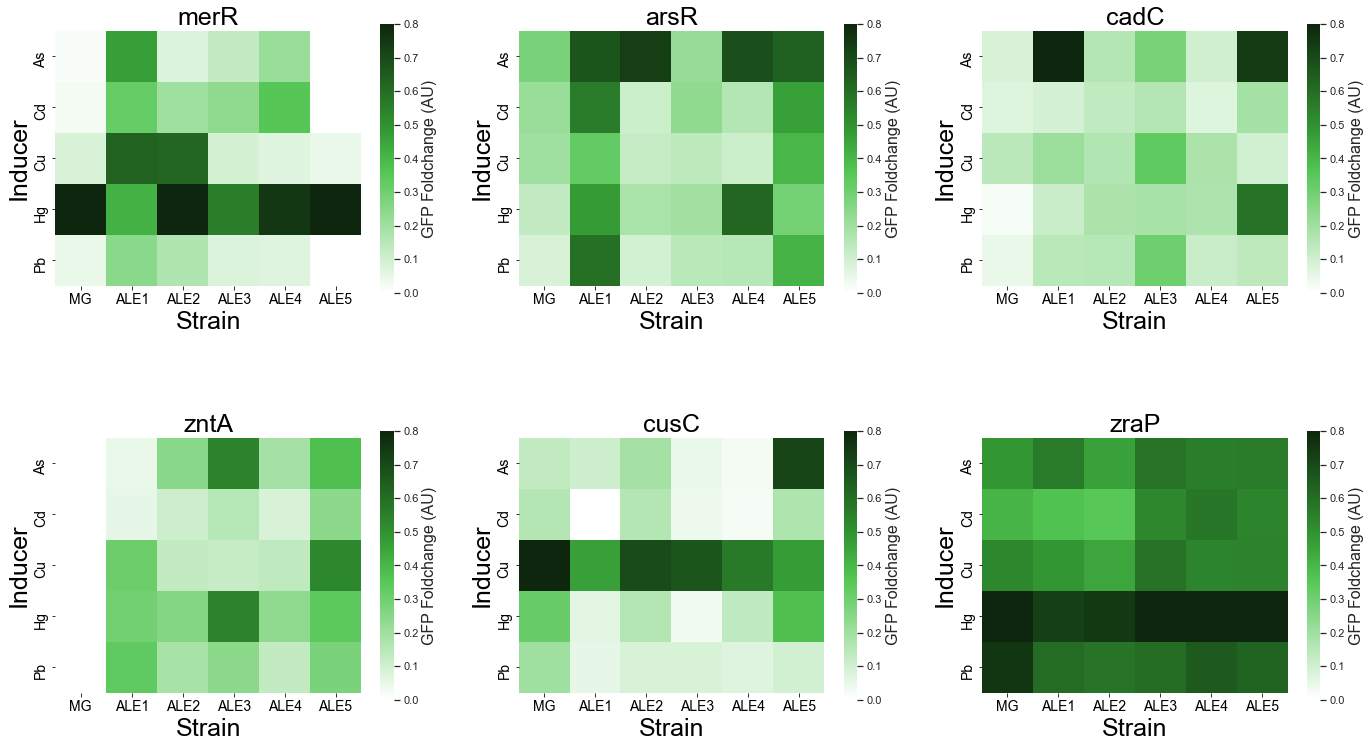

In [7]:
spec_df = pd.read_csv('spec.csv')

vmin = 0
vmax = 0.8

# Create a figure with subplots
fig, axes = plt.subplots(2, 3)  # Creates a 2x2 grid of subplots
fig.set_figheight(12)
fig.set_figwidth(20)
fig.tight_layout(pad=5.0)

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#ffffff','#53c653','#339933','#206020', '#0d260d'] # White to Green
th = [0, 0.45, 0.6, 0.8, 1]

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

hm_sensor = ['merR','arsR', 'cadC','zntA', 'cusC','zraP']
xticks = ['MG','ALE1','ALE2','ALE3','ALE4','ALE5']
hm_order = ['As','Cd','Cu','Hg','Pb']

n=0
for i in hm_sensor: 
    filtered_df = spec_df[spec_df['strain'].str.contains(i)]
    filtered_df = filtered_df.pivot(index="concentration", columns="strain", values="foldchange")
    # Build the desired column order for this sensor (e.g., ["cusC_MG","cusC_ALE1",...])
    col_order = [f"{i}_{x}" for x in xticks]

    # Reorder columns (keeps only those that exist; missing ones become all-NaN columns)
    filtered_df = filtered_df.reindex(columns=col_order)

    if n < 3: 
        ax = axes[0,n]
    else:
        ax = axes[1,n-3]
    n=n+1 
    sns.set(font_scale=1)
    sns.heatmap(filtered_df, cmap=cm, square=True, ax=ax,xticklabels=xticks,cbar_kws={"shrink": 0.8},vmin=vmin, vmax=vmax)
                #"PuBuGn",square=True, ax=ax)
    ax.figure.axes[-1].set_ylabel('GFP Foldchange (AU)', size=16)
    ax.set_ylabel('Inducer', fontsize=25)
    ax.set_xlabel("Strain", fontsize=25)
    ax.set_title(i, fontsize=25)
    ax.set_xticklabels(xticks,fontsize=14)
    ax.set_yticklabels(hm_order, fontsize=14)